In [1]:
import numpy as np
import pandas as pd
import pickle
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score as r2
import catboost as catb
import xgboost as xgb

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix,
                             accuracy_score, classification_report, plot_confusion_matrix,
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve, f1_score)
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def evaluate_preds(model, X_train, X_valid, y_train, y_valid):
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    print("TRAIN\n", round(f1_score(y_train, y_train_pred), 3))
    print("TEST\n", round(f1_score(y_valid, y_valid_pred), 3))
    get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

In [5]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [6]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [7]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

Задача. Требуется на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

Целевая переменная Credit Default - факт невыполнения кредитных обязательств

Метрика качества F1-score (sklearn.metrics.f1_score)

Целевая метрика F1 > 0.5 Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

Значения полей датасета: Home Ownership - домовладение

Annual Income - годовой доход

Years in current job - количество лет на текущем месте работы

Tax Liens - налоговые обременения

Number of Open Accounts - количество открытых счетов

Years of Credit History - количество лет кредитной истории

Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)

Number of Credit Problems - количество проблем с кредитом

Months since last delinquent - количество месяцев с последней просрочки платежа

Bankruptcies - банкротства

Purpose - цель кредита

Term - срок кредита

Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)

Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)

Monthly Debt - ежемесячный долг

Credit Score - баллы кредитного рейтинга

Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [8]:
test_df = pd.read_csv("C://Users//Артур//Downloads//course_project//course_project_test.csv")

In [9]:
train_df = pd.read_csv("C://Users//Артур//Downloads//course_project//course_project_train.csv")

1. Обзор обучающего датасета

In [10]:
train_df.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0
7499,Rent,NaN,4 years,0.0,8.0,9.4,480832.0,0.0,NaN,0.0,debt consolidation,Short Term,26928.0,288192.0,9061.0,NaN,0


In [11]:
train_df.rename(columns={'Years in current job': 'Years_in_current_job'}, inplace=True)
train_df.rename(columns={'Home Ownership': 'Home_Ownership'}, inplace=True)

In [12]:
train_df.describe().round()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5943.0,7500.0,7500.0,7500.0,7.500000e+03,7500.0,3419.0,7486.0,7500.0,7500.0,7500.0,5943.0,7500.0
mean,1366392.0,0.0,11.0,18.0,9.451540e+05,0.0,35.0,0.0,11873177.0,289833.0,18314.0,1151.0,0.0
std,845339.0,0.0,5.0,7.0,1.602622e+07,0.0,22.0,0.0,31926123.0,317871.0,11927.0,1604.0,0.0
min,164597.0,0.0,2.0,4.0,0.000000e+00,0.0,0.0,0.0,11242.0,0.0,0.0,585.0,0.0
25%,844341.0,0.0,8.0,14.0,2.792300e+05,0.0,16.0,0.0,180169.0,114256.0,10068.0,711.0,0.0
50%,1168386.0,0.0,10.0,17.0,4.781590e+05,0.0,32.0,0.0,309573.0,209323.0,16076.0,731.0,0.0
75%,1640137.0,0.0,14.0,22.0,7.935020e+05,0.0,50.0,0.0,519882.0,360406.0,23818.0,743.0,1.0
max,10149344.0,7.0,43.0,58.0,1.304726e+09,7.0,118.0,4.0,99999999.0,6506797.0,136679.0,7510.0,1.0


In [13]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 7500
Строк в тесте 2500


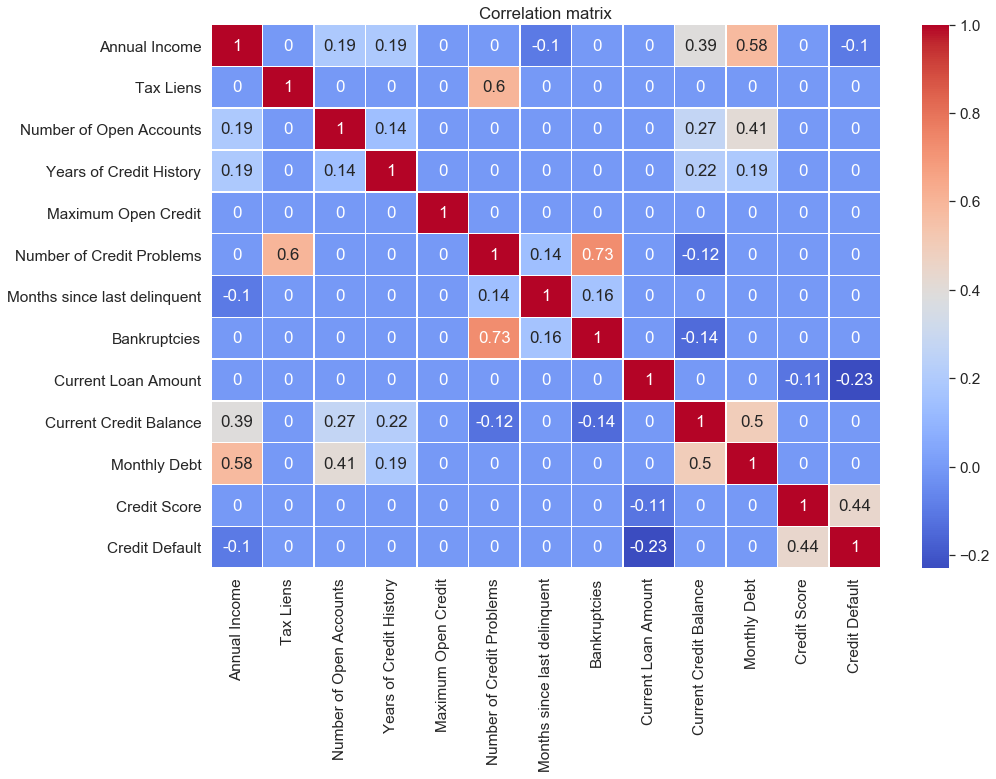

In [14]:
#Построим матрицу корреляций
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.1] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [15]:
train_df.dtypes

Home_Ownership                   object
Annual Income                   float64
Years_in_current_job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [16]:
for colname in ['Years_in_current_job', 'Purpose', 'Term', 'Home_Ownership']:
    train_df[colname] = train_df[colname].astype(str)

In [17]:
for cat_colname in train_df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home_Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home_Ownership, dtype: int64
****************************************************************************************************

Years_in_current_job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
nan           371
8 years       339
9 years       259
Name: Years_in_current_job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses 

In [18]:
TARGET_NAME = 'Credit Default'
NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                     'Number of Credit Problems', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home_Ownership', 'Years_in_current_job', 'Purpose', 'Term']

2. Обработка пропусков

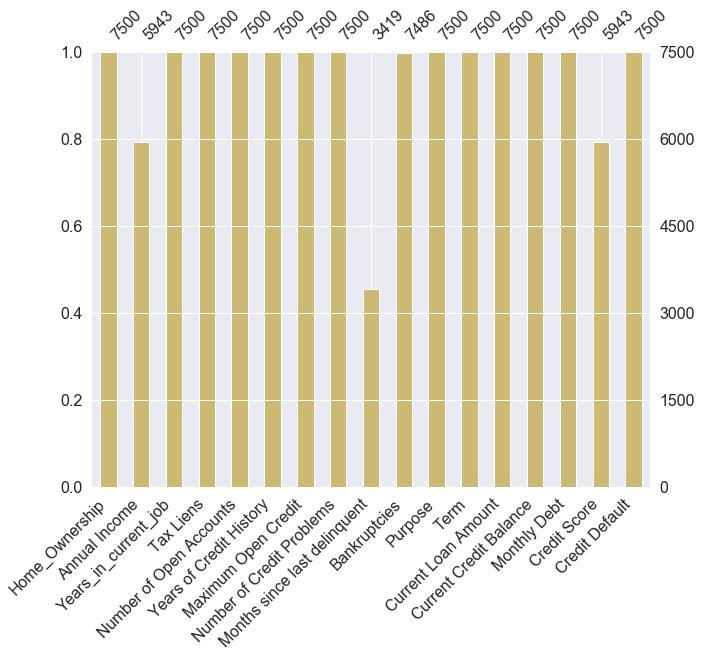

In [19]:
#Построим гистограмму, чтобы визуализировать пропуски
import missingno as msno
msno.bar(train_df, color = 'y', figsize = (10,8))

In [20]:
#Теперь посмотрим сколько их в колличественном и в процентном соотношении
total = train_df.isnull().sum().sort_values(ascending=False)
percent = ((train_df.isnull().sum()/train_df.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Months since last delinquent,4081,54.413333
Annual Income,1557,20.760000
Credit Score,1557,20.760000
Bankruptcies,14,0.186667
Maximum Open Credit,0,0.000000
Years_in_current_job,0,0.000000
Tax Liens,0,0.000000
Number of Open Accounts,0,0.000000
Years of Credit History,0,0.000000
Credit Default,0,0.000000


В наших данных пропуски имеются в признаках Months since last delinquent, Annual Income, Credit Score, Years in current job, 
и Bankruptcies

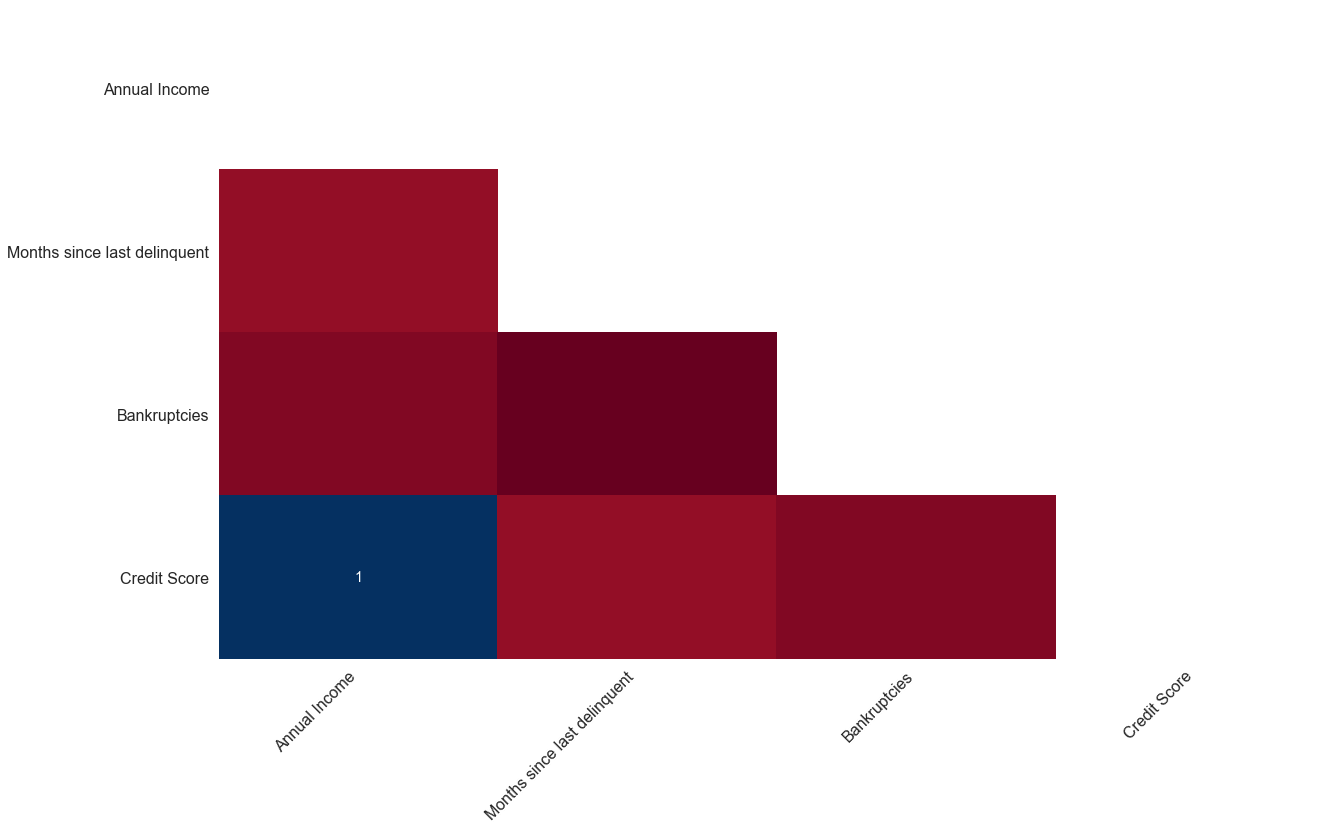

In [21]:
#Посмотрим есть ли корреляция между пропусками
msno.heatmap(train_df)

Видим что пропуски в Credit Score и Annual Income имеют сильную корреляцию,
будем иметь это ввиду при обработке пропусков.

В признаке Months since last delinquent 54% пропусков, так как признак означает колличество месяцев с последней просрочки, то логично было бы заполнить пропуски 0 (то есть не было просрочек), но так как пропусков больше половины и нет линейной зависимости с целевым признаком то удалим весь столбец

In [22]:
train_df.drop('Months since last delinquent', axis=1, inplace=True)

Посмотрим на признак Years in current job, он у нас категориальный

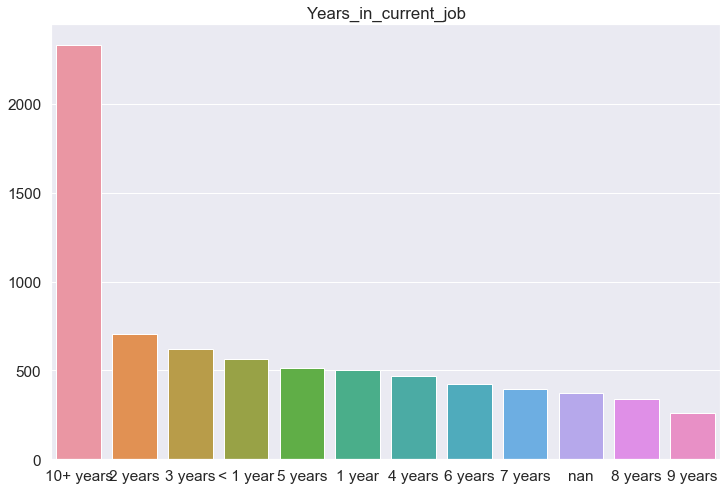

In [23]:
counts = train_df['Years_in_current_job'].value_counts()
    
plt.figure(figsize=(12, 8))    
plt.title('Years_in_current_job')
sns.barplot(counts.index, counts.values)
    
plt.show()

Пропуски данного признака можно заполнить либо самым встречающимся значением 10+years, либо использовать метод ffill/bfil, поскольку это позволяет распределять данные.

In [24]:
#Поскольку у нас не очень большой набор данных то будем использовать первый метод
train_df['Years_in_current_job'].fillna(train_df['Years_in_current_job'].value_counts().index[0], inplace = True)

Посмотрим на признак Bankruptcies, у него 14 порпусков и он имеет сильную линейную корреляцию с Number of Credit Problems

In [25]:
#Учитывая сильную линейную корреляцию признака с Number of Credit Problems, создадим новый признак 
#и 0 пометим отсутствие пропусков а 1 присутствие
train_df['Bankruptcies_nan'] = 0
train_df.loc[train_df['Bankruptcies'].isnull(), 'Bankruptcies_nan'] = 1

In [26]:
#Можем убедиться что все пропсуки признака Bankruptcies расположены при Number of Credit Problems равным 0
train_df[(train_df['Bankruptcies_nan'] == 1) & (train_df['Number of Credit Problems'] == 0)].head(14)

,Home_Ownership,Annual Income,Years_in_current_job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Bankruptcies_nan
100,Own Home,337079.0,1 year,0.0,9.0,39.6,644204.0,0.0,NaN,educational expenses,Short Term,99999999.0,224770.0,4326.0,734.0,0,1
256,Rent,857660.0,1 year,0.0,6.0,19.7,291082.0,0.0,NaN,debt consolidation,Short Term,99999999.0,236816.0,3488.0,743.0,0,1
257,Home Mortgage,NaN,2 years,0.0,15.0,13.6,1556390.0,0.0,NaN,debt consolidation,Short Term,447480.0,524210.0,19613.0,NaN,0,1
898,Rent,739005.0,2 years,0.0,20.0,18.3,2177758.0,0.0,NaN,debt consolidation,Short Term,456808.0,607487.0,9669.0,732.0,1,1
1404,Rent,349391.0,< 1 year,0.0,4.0,12.7,0.0,0.0,NaN,other,Short Term,11242.0,0.0,1243.0,747.0,0,1
3063,Rent,464474.0,10+ years,0.0,5.0,14.9,38126.0,0.0,NaN,other,Short Term,44814.0,18373.0,929.0,7490.0,1,1
3252,Rent,832770.0,< 1 year,0.0,7.0,16.5,636856.0,0.0,NaN,business loan,Short Term,156970.0,52250.0,1145.0,750.0,0,1
3351,Home Mortgage,2226192.0,8 years,0.0,14.0,23.3,792836.0,0.0,NaN,debt consolidation,Short Term,528968.0,625157.0,23746.0,674.0,0,1
3401,Rent,326154.0,6 years,0.0,2.0,19.1,0.0,0.0,NaN,other,Short Term,99999999.0,0.0,1245.0,712.0,0,1
3496,Rent,233567.0,1 year,0.0,7.0,11.7,0.0,0.0,NaN,educational expenses,Short Term,210166.0,0.0,0.0,746.0,0,1


In [27]:
#Тогда заполним пропуски признака Bankruptcies 0
train_df['Bankruptcies'].fillna(0, inplace = True)

Посмотрим на признаки Annual Income и Credit Score,
Мы уже упоминали выше что пропуски в этих признаках зависимы, но так как у данных признаков нет линейной корреляции, 
признаки числовые и имеют выбросы, то заменим пропуски медианой.

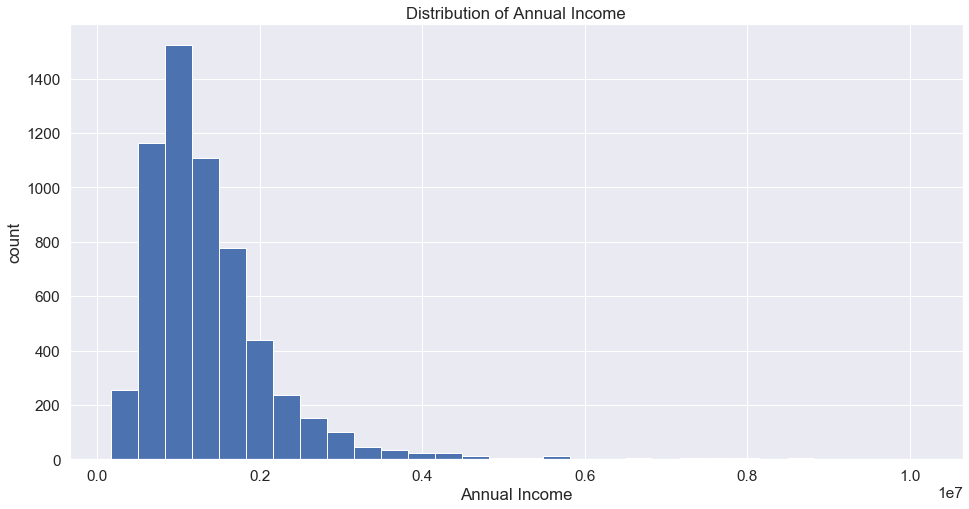

In [28]:
plt.figure(figsize=(16, 8))

train_df['Annual Income'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('Annual Income')

plt.title('Distribution of Annual Income')
plt.show()

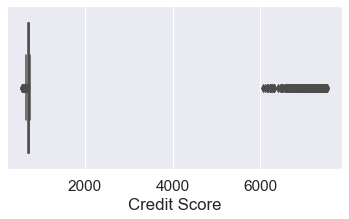

In [29]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Credit Score'], whis=1.5)

plt.xlabel('Credit Score')
plt.show()

In [30]:
train_df['Annual Income'].fillna(train_df['Annual Income'].median(), inplace = True)

In [31]:
train_df['Credit Score'].fillna(train_df['Credit Score'].median(), inplace = True)

3. Обработка выбросов

Посмотрим на признаки

In [32]:
target = 'Credit Default'
numfeat, catfeat = list(train_df.select_dtypes(include=np.number)), list(train_df.select_dtypes(exclude=np.number)); numfeat.remove(target)

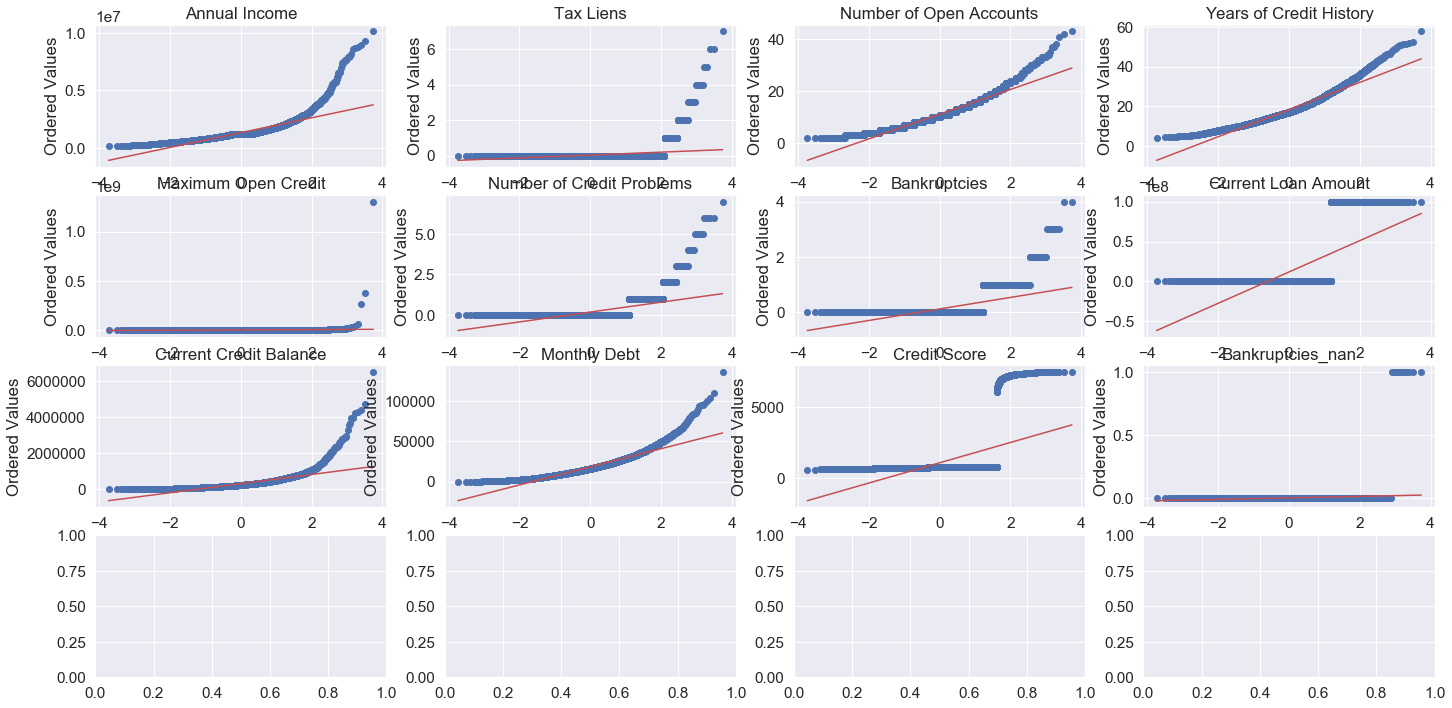

In [33]:
f, a = plt.subplots(4,4, figsize=(24,12))
a = a.flatten().T
for i, col in enumerate(train_df[numfeat].columns):
    stats.probplot(train_df[col], plot=a[i])
    a[i].set_title(col)
plt.show()

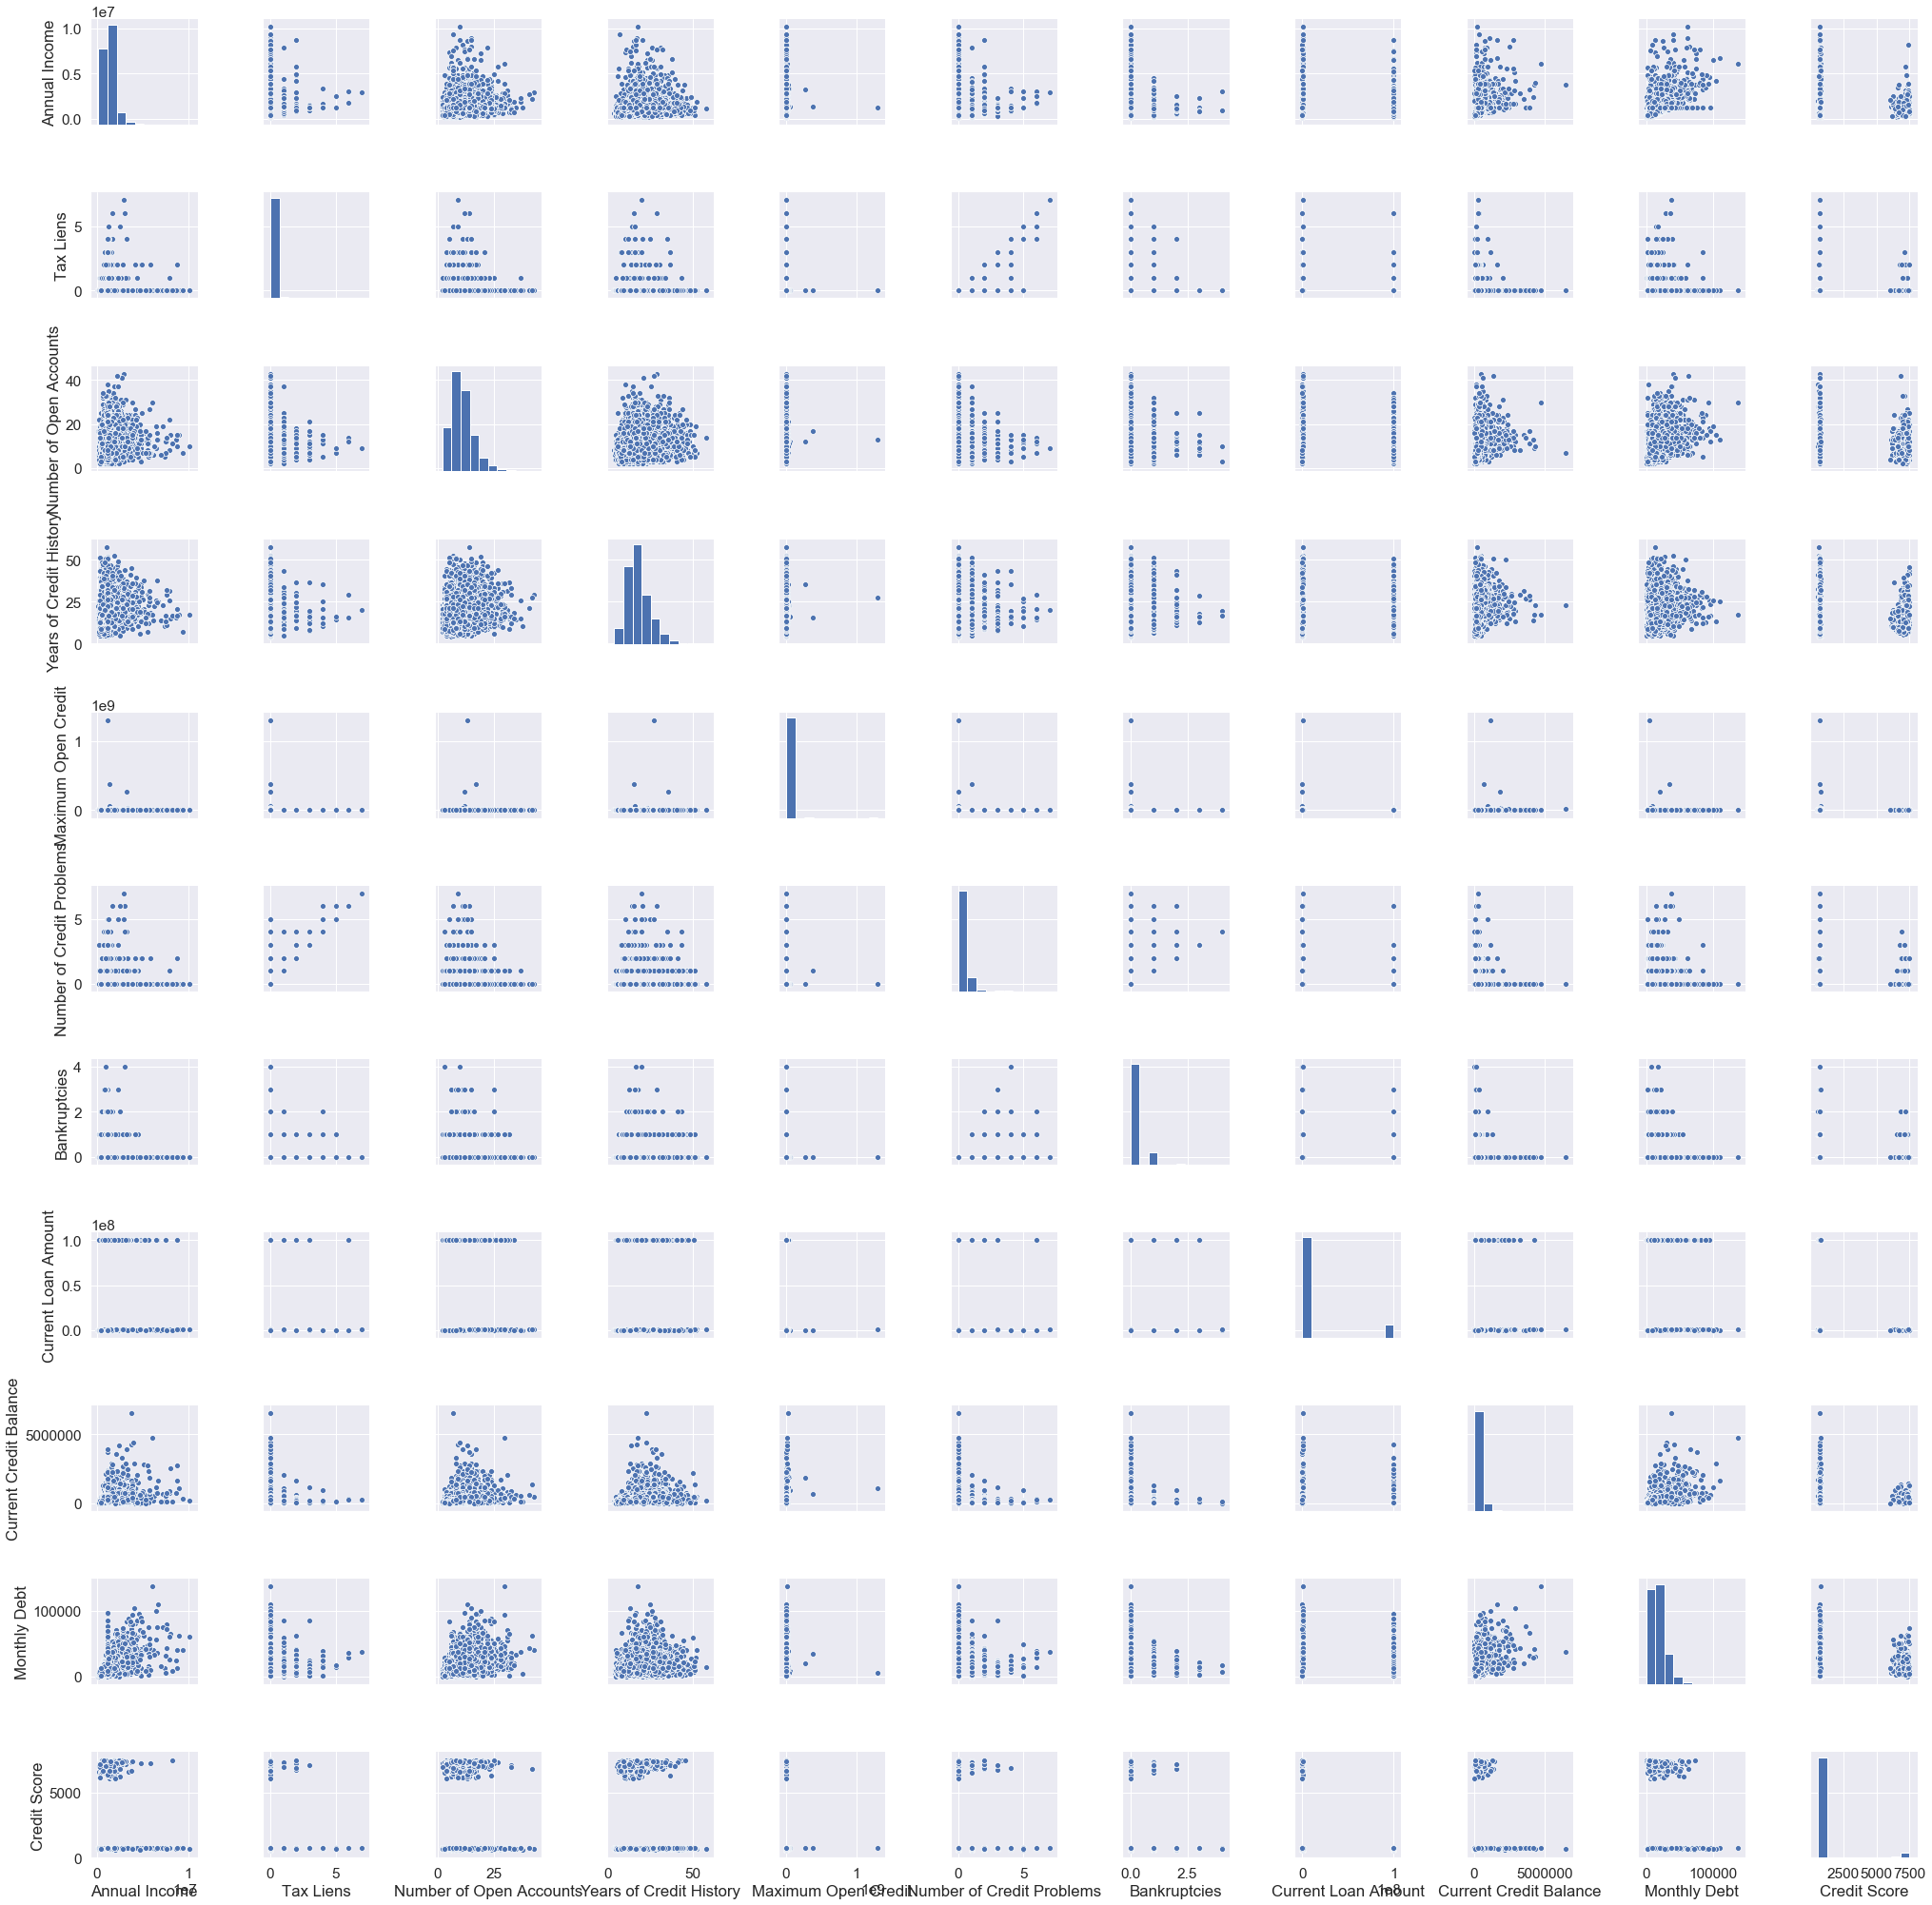

In [34]:
sns.pairplot(train_df[NUM_FEATURE_NAMES]); plt.show()

Признаки в которых мы будем обрабатывать выбросы:
- Maximum Open Credit
- Current Loan Amount
- Credit Score

Визуализируем выбросы признака Maximum Open Credit

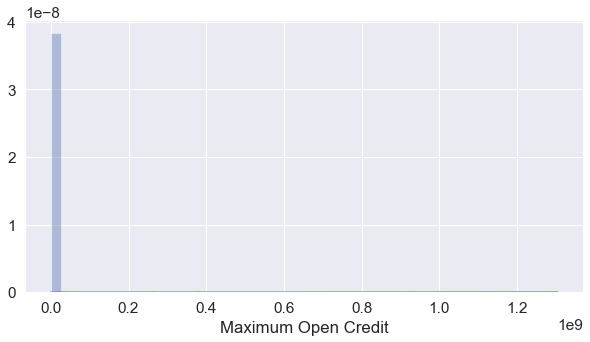

In [35]:
plt.figure(figsize = (10,5))
sns.distplot(train_df['Maximum Open Credit'])

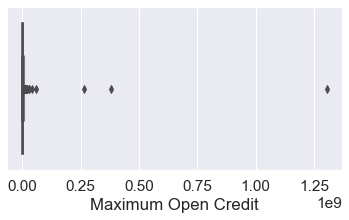

In [36]:
plt.figure(figsize=(6, 3))
sns.boxplot(train_df['Maximum Open Credit'], whis=10)
plt.xlabel('Maximum Open Credit')
plt.show()

In [37]:
# Давайте определим функцию для определения IQR, нижнего и верхнего усов.
def out_iqr(df , column):
    global lower,upper
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    # calculate the IQR
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    # calculate the lower and upper bound value
    lower, upper = q25 - cut_off, q75 + cut_off
    print('The IQR is',iqr)
    print('The lower bound value is', lower)
    print('The upper bound value is', upper)
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    return print('Total number of outliers are', df1.shape[0]+ df2.shape[0])

In [38]:
out_iqr(train_df,'Maximum Open Credit')

The IQR is 514272.0
The lower bound value is -492178.5
The upper bound value is 1564909.5
Total number of outliers are 466


Из визуализации и расчёта выбросов видно что выбросами определяются значения больше 1379669.5 в признаке Maximum Open Credit, а также видим два экстремальных значения, заменим значения больше 1379669.5 медианой.

In [39]:
train_df.loc[train_df['Maximum Open Credit'] >= 1000000, 'Maximum Open Credit'] = train_df['Maximum Open Credit'].median()

Посмотрим на признак Current Loan Amount

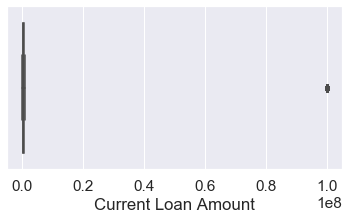

In [40]:
plt.figure(figsize=(6, 3))
sns.boxplot(train_df['Current Loan Amount'], whis=10)
plt.xlabel('Current Loan Amount')
plt.show()

In [41]:
out_iqr(train_df,'Current Loan Amount')

The IQR is 339713.0
The lower bound value is -329400.5
The upper bound value is 1029451.5
Total number of outliers are 870


In [42]:
train_df['Current Loan Amount'].max()

99999999.0

Видим что есть экстремальные значения равные 99999999.0 что совершенно точно выбросы, заменим их медианой.

In [43]:
train_df.loc[train_df['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = train_df['Current Loan Amount'].median()

Посмотрим на признак Credit Score

Значения Credit Score могут быть в диапазоне 300–850

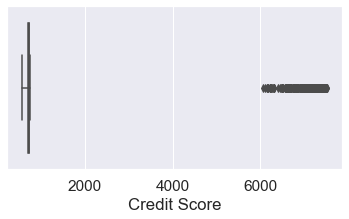

In [44]:
plt.figure(figsize=(6, 3))
sns.boxplot(train_df['Credit Score'], whis=10)
plt.xlabel('Credit Score')
plt.show()

In [45]:
train_df[train_df['Credit Score'] > 850]['Credit Score'].count()

400

Разделим значения более 850 на 10

In [46]:
train_df.loc[train_df['Credit Score'] > 850, 'Credit Score'] = train_df.loc[train_df['Credit Score'] > 850, 'Credit Score'] / 10

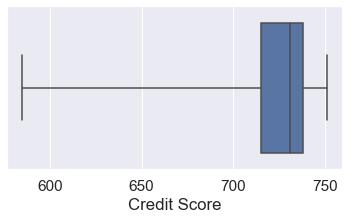

In [47]:
plt.figure(figsize=(6, 3))
sns.boxplot(train_df['Credit Score'], whis=10)
plt.xlabel('Credit Score')
plt.show()

4. Обработка категориальных признаков и построение новых признаков

In [48]:
train_df['ID'] = train_df.index.tolist()

Признак Home_Ownership, для его обработки используем метод dummies.

In [49]:
pd.get_dummies(train_df['Home_Ownership'])
train_df = pd.concat([train_df, pd.get_dummies(train_df['Home_Ownership'])], axis=1)

Посмотрим на признак Term, который означает краткосрочный кредит или долгосрочный, содержащий в себе два значения
Long Term и Short Term, создадим новый признак Long Term, в котором 1 это долгосрочный и 2 краткосрочный кредит.

In [50]:
train_df['Long Term'] = train_df['Term'].map({'Long Term': 1, 'Short Term': 0})

В прризнаке Purpose очень много категрий, с помощью частотного анализа в разрезе целевой переменной попробуем уменьшить число категорий до major purchase (крупные покупки), business loan (кредит на бизнес), medical bills (медицинские расходы), recreation (развлечения), other (прочее), debt consolidation (рефинансирование займа), education (расходы на образование) и renewable energy (возобновляемая энергия)

In [51]:
train_df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

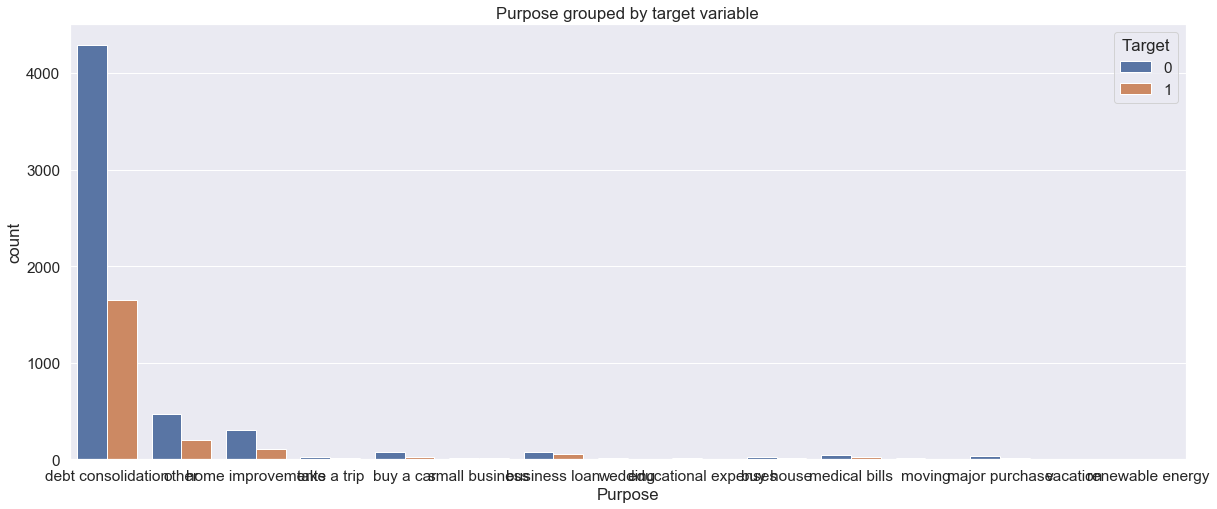

In [52]:
plt.figure(figsize=(20, 8))

sns.countplot(x="Purpose", hue=TARGET_NAME, data=train_df)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Изучив получившийся график, видно, что значения 'by a car', 'major purchase' и 'buy house' призака Purpose имеют схожие доли в разрезе целевой переменной. Если это действительно так, то считаю будет логичным объеденить их в одну категорию 'major purchase', то есть объеденим все крупные покупки в одну категорию

Если в ячейке больше больше 10 значений то будем применять хи-квадрат, если меньше 10 то применим попровку Йетса (запускается correction=True в chi2_contingency), если меньше 5 то будем использовать точный тест Фишера

Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
Критерий: Хи-квадрат Пирсона
Уровень значимости  α : 0.05

Сформируем выборку 

In [53]:
purpose_and_target_s = train_df.loc[train_df['Purpose'].isin(['buy a car', 'major purchase', 'buy house']), ['ID', 'Purpose', 'Credit Default']].sample(72)

Рассчитаем наблюдаемые частоты

In [54]:
table = purpose_and_target_s.pivot_table(values='ID', index='Purpose', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Purpose,,
buy a car,34,9
buy house,9,2
major purchase,14,4


In [55]:
chi2, p, dof, expected = chi2_contingency(table, correction=True)
p

0.9664809499381876

P-value получилось больше выбранного уровня значимости, соответственно у нас нет оснований для отвержения нулевой гипотезы и можно допустить, что категории buy a car, buy house и major purchase одинаково влияют на целевую переменную и их можно объединить в одну категорию.

Посмотрим можем ли мы объеденить категории take a trip (путешествие), moving (переезд), vacation (отпуск) и wedding (свадьба) в fun (развлечения)

In [56]:
purpose_and_target_s2 = train_df.loc[train_df['Purpose'].isin(['moving', 'vacation']), ['ID', 'Purpose', 'Credit Default']].sample(12)
table2 = purpose_and_target_s2.pivot_table(values='ID', index='Purpose', columns='Credit Default', aggfunc='count')
table2

Credit Default,0,1
Purpose,,
moving,6,1
vacation,4,1


In [57]:
oddsr, p = fisher_exact(table2, alternative='two-sided')
p

1.0

P-value получилось больше выбранного уровня значимости, соответственно у нас нет оснований для отвержения нулевой гипотезы и можно допустить, что категории take a trip, moving, vacation, wedding в обну категорию. Так как тест Фишера применяется на таблицы 2x2, то тест был сделан по отношению ко всем парам. применить его ко всем одним разом либо заменить тест другим не удалось.

Объеденим категории признака Purpose

In [58]:
dct = {'take a trip': 'Purpos_fun', 'moving': 'Purpos_fun', 'vacation': 'Purpos_fun', 'wedding': 'Purpos_fun', 'small business': 'Purpos_business loan', 'buy a car': 'Purpos_major purchase', 'buy house': 'Purpos_major purchase', 'home improvements': 'Purpos_other', 'educational expenses': 'Purpos_educational expenses', 'medical bills': 'Purpos_medical bills', 'debt consolidation': 'Purpos_debt consolidation', 'renewable energy': 'Purpos_renewable energy', 'other': 'Purpos_other', 'business loan': 'Purpos_business loan', 'major purchase': 'Purpos_major purchase'}
train_df['Purpose'] = train_df['Purpose'].map(dct)

In [59]:
train_df['Purpose'].value_counts()

Purpos_debt consolidation      5944
Purpos_other                   1077
Purpos_major purchase           170
Purpos_business loan            155
Purpos_medical bills             71
Purpos_fun                       71
Purpos_educational expenses      10
Purpos_renewable energy           2
Name: Purpose, dtype: int64

In [60]:
pd.get_dummies(train_df['Purpose'])
train_df = pd.concat([train_df, pd.get_dummies(train_df['Purpose'])], axis=1)

In [61]:
train_df.head()

,Home_Ownership,Annual Income,Years_in_current_job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,...,Rent,Long Term,Purpos_business loan,Purpos_debt consolidation,Purpos_educational expenses,Purpos_fun,Purpos_major purchase,Purpos_medical bills,Purpos_other,Purpos_renewable energy
0,Own Home,482087.0,nan,0.0,11.0,26.3,685960.0,1.0,1.0,Purpos_debt consolidation,...,0,0,0,1,0,0,0,0,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,478159.0,0.0,0.0,Purpos_debt consolidation,...,0,1,0,1,0,0,0,0,0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,478159.0,0.0,0.0,Purpos_debt consolidation,...,0,0,0,1,0,0,0,0,0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,1.0,Purpos_debt consolidation,...,0,0,0,1,0,0,0,0,0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,Purpos_debt consolidation,...,1,0,0,1,0,0,0,0,0,0


При создании новых признаков будем пользоваться статистическим анализом по отношению к целевой переменной
Проанализируем признак Number of Open Accounts (колличество открытых счетов) на то полезен ли он для определения целевой переменной

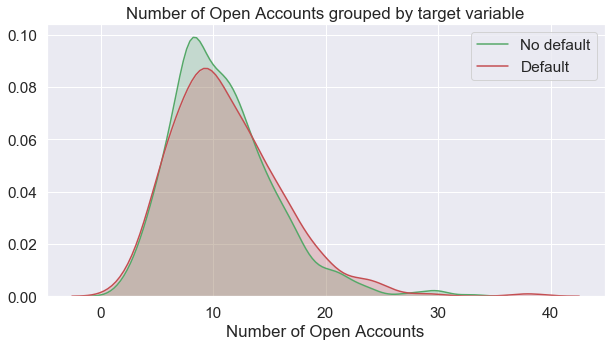

In [62]:
open_accounts_with_target_s = train_df[['Number of Open Accounts', TARGET_NAME]].sample(1000)
open_accounts_s = open_accounts_with_target_s['Number of Open Accounts']
open_accounts_target_0 = open_accounts_s[open_accounts_with_target_s[TARGET_NAME] == 0]
open_accounts_target_1 = open_accounts_s[open_accounts_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(open_accounts_target_0, shade=True, label='No default', color='g')
sns.kdeplot(open_accounts_target_1, shade=True, label='Default', color='r')

plt.xlabel('Number of Open Accounts')
plt.title('Number of Open Accounts grouped by target variable')
plt.show()

Наблюдения

Похоже что две группы, полученные в результате разбиения признака "Number of Open Accounts" по целевой переменной, имеют почти одинаковое распределения, что не поможет при построение модели, т.к. это будет означать, что между признаком "Number of Open Accounts" и целевой переменной, возможно, отсутствует некоторая функциональная зависимость.

Гипотеза

Нулевая гипотеза: средние значения в двух независимых выборках равны
Альтернативная гипотеза: средние значения в двух независимых выборках различаются
Критерий: критерий Стьюдента (t-тест) и его аналоги
Уровень значимости  α : 0.05
Критическая область: двухсторонняя

Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка

In [63]:
shapiro(open_accounts_s)

(0.9421541690826416, 2.614970723354832e-19)

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график

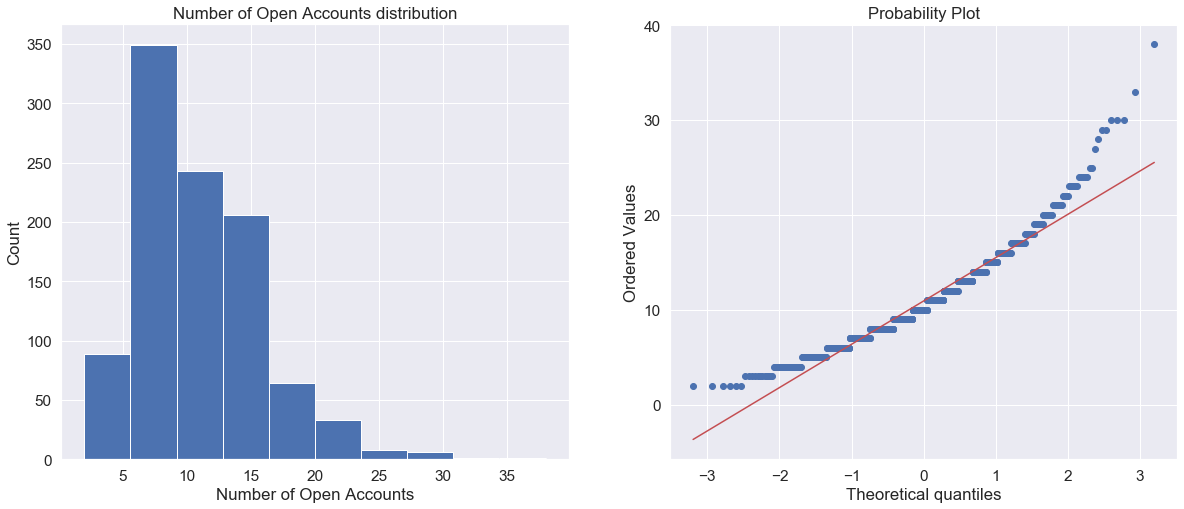

In [64]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Number of Open Accounts')
ax1.set_ylabel('Count')
ax1.set_title('Number of Open Accounts distribution')
open_accounts_s.hist()

plt.subplot(122)
probplot(open_accounts_s, dist='norm', plot=plt)

plt.show()

Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака Number of Open Accounts в группах с просроченным и непросроченным платежом в следующем месяце, но мы сможем воспользоваться его непараметрическим аналогом - критерием Манна-Уитни, который не требователен к закону распределения

In [65]:
mannwhitneyu(open_accounts_target_0, open_accounts_target_1)

MannwhitneyuResult(statistic=98742.0, pvalue=0.1320222381557346)

Согласно значению p-value, гипотеза о равности мат. ожиданий потверждается, но стоит ради дополнительной проверки обратиться к доверительным интервалам

Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их

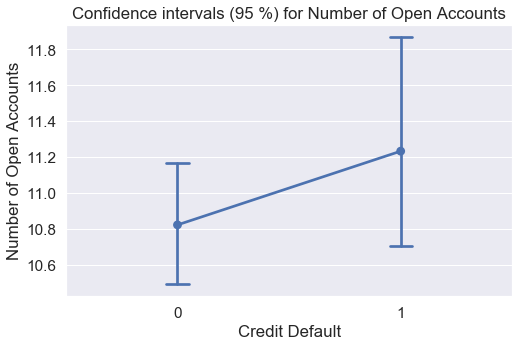

In [66]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Number of Open Accounts', data=open_accounts_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Number of Open Accounts')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.
Этот признак может быть не полезен для определения значения целевой переменной.

Признак Number of Open Accounts у нас вещественый, обработаем его методом Feature discretization

In [67]:
def number_accounts_to_cat(X):

    X['number_accounts_to_cat'] = 0

    X.loc[X['Number of Open Accounts'] <= 10, 'number_accounts_to_cat'] = 1  
    X.loc[(X['Number of Open Accounts'] > 10) & (X['Number of Open Accounts'] <= 20), 'number_accounts_to_cat'] = 2
    X.loc[(X['Number of Open Accounts'] > 20) & (X['Number of Open Accounts'] <= 30), 'number_accounts_to_cat'] = 3
    X.loc[X['Number of Open Accounts'] > 43, 'number_accounts_to_cat'] = 4

    return X

In [68]:
train_df = number_accounts_to_cat(train_df)
train_df.head()

,Home_Ownership,Annual Income,Years_in_current_job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,...,Long Term,Purpos_business loan,Purpos_debt consolidation,Purpos_educational expenses,Purpos_fun,Purpos_major purchase,Purpos_medical bills,Purpos_other,Purpos_renewable energy,number_accounts_to_cat
0,Own Home,482087.0,nan,0.0,11.0,26.3,685960.0,1.0,1.0,Purpos_debt consolidation,...,0,0,1,0,0,0,0,0,0,2
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,478159.0,0.0,0.0,Purpos_debt consolidation,...,1,0,1,0,0,0,0,0,0,2
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,478159.0,0.0,0.0,Purpos_debt consolidation,...,0,0,1,0,0,0,0,0,0,2
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,1.0,Purpos_debt consolidation,...,0,0,1,0,0,0,0,0,0,1
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,Purpos_debt consolidation,...,0,0,1,0,0,0,0,0,0,2


Создадим единый класс предобработки наших данных с помощью функции python

In [69]:
class DataPreprocessing:
    """Подготовка исходных данных"""
    def __init__(self):
        """Параметры класса"""
        
        
    def fit(self, X):
        """Сохранение статистик"""       
        

    
    def transform(self, X):
        """Трансформация данных"""

        # Months since last delinquent
        X.drop('Months since last delinquent', axis=1, inplace=True)
        
        # Rename
        X.rename(columns={'Years in current job': 'Years_in_current_job'}, inplace=True)
        X.rename(columns={'Home Ownership': 'Home_Ownership'}, inplace=True)  
        
        # Astype
        for colname in ['Years_in_current_job', 'Purpose', 'Term', 'Home_Ownership']: X[colname] = X[colname].astype(str)
        
        # Years_in_current_job
        X['Years_in_current_job'].fillna(X['Years_in_current_job'].value_counts().index[0], inplace = True)
        
        # Bankruptcies
        X['Bankruptcies_nan'] = 0
        X.loc[X['Bankruptcies'].isnull(), 'Bankruptcies_nan'] = 1
        X['Bankruptcies'].fillna(0, inplace = True)
        
        # Annual Income 
        X['Annual Income'].fillna(X['Annual Income'].median(), inplace = True)

        
        # Credit Score
        X['Credit Score'].fillna(X['Credit Score'].median(), inplace = True)
        
        
        # Maximum Open Credit
        X.loc[X['Maximum Open Credit'] >= 1000000, 'Maximum Open Credit'] = X['Maximum Open Credit'].median()
        
        # Current Loan Amount
        X.loc[X['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = X['Current Loan Amount'].median()
        
        # Credit Score
        X.loc[X['Credit Score'] > 850, 'Credit Score'] = X.loc[X['Credit Score'] > 850, 'Credit Score'] / 10
        
        return X


Создадим класс python для генерации новых фич, и вставим туда все наши алгоритмы

In [70]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.dict2 = None
        self.dict = None
        self.med_target_Home_Ownership = None
                        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.dict = {'take a trip': 'Purpos_fun', 'moving': 'Purpos_fun', 'vacation': 'Purpos_fun', 'wedding': 'Purpos_fun', 
                                  'small business': 'Purpos_business loan', 'buy a car': 'Purpos_major purchase', 'buy house': 'Purpos_major purchase', 
                                  'home improvements': 'Purpos_other', 'educational expenses': 'Purpos_educational expenses', 'medical bills': 'Purpos_medical bills', 
                                  'debt consolidation': 'Purpos_debt consolidation', 'renewable energy': 'Purpos_renewable energy', 'other': 'Purpos_other', 
                                  'business loan': 'Purpos_business loan', 'major purchase': 'Purpos_major purchase'}
        self.dict2 = {'Long Term': 1, 'Short Term': 0}
                                        
        
    def transform(self, X):
        
        # Binary features
        X['Purpose'] = X['Purpose'].map(self.dict)
        X['Long Term'] = X['Term'].map(self.dict2)
                
        # Purpose
        X = pd.concat([X, pd.get_dummies(X['Purpose'])], axis=1)
        
        # Home_Ownership
        X = pd.concat([X, pd.get_dummies(X['Home_Ownership'])], axis=1)
              
        # More categorical features
        X = self.number_accounts_to_cat(X)
                
        # Target encoding
                   
             
        return X
    
    def number_accounts_to_cat(self, X):

        X['number_accounts_to_cat'] = 0

        X.loc[X['Number of Open Accounts'] <= 10, 'number_accounts_to_cat'] = 1  
        X.loc[(X['Number of Open Accounts'] > 10) & (X['Number of Open Accounts'] <= 20), 'number_accounts_to_cat'] = 2
        X.loc[(X['Number of Open Accounts'] > 20) & (X['Number of Open Accounts'] <= 30), 'number_accounts_to_cat'] = 3
        X.loc[X['Number of Open Accounts'] > 43, 'number_accounts_to_cat'] = 4

        return X

Выделение целевой переменной и групп признаков

In [71]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = ['Annual Income', 'Tax Liens',
                      'Number of Open Accounts', 'Years of Credit History',
                      'Maximum Open Credit', 'Number of Credit Problems',
                      'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 
                      'Monthly Debt', 'Credit Score']
NEW_FEATURE_NAMES = ['Long Term', 'Purpos_business loan', 'Purpos_debt consolidation', 
                     'Purpos_educational expenses', 'Purpos_fun', 'Purpos_major purchase', 'Purpos_medical bills', 
                     'Purpos_other', 'Purpos_renewable energy','number_accounts_to_cat', 'Own Home', 'Rent',
                     'Home Mortgage','Have Mortgage']

Отбор признаков

In [72]:
NUMERIC_FEATURE_NAMES = ['Annual Income', 'Tax Liens',
                         'Number of Open Accounts', 'Years of Credit History',
                         'Maximum Open Credit', 'Number of Credit Problems',
                         'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 
                         'Monthly Debt', 'Credit Score']

FEATURE_NAMES_SELECTED = NUMERIC_FEATURE_NAMES + NEW_FEATURE_NAMES

Нормализация данных

In [73]:
scaler = StandardScaler()

df_norm = train_df.copy()
df_norm[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMERIC_FEATURE_NAMES])

train_df = df_norm.copy()

Разбиение на train и test

In [94]:
X = train_df[FEATURE_NAMES_SELECTED]
y = train_df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21, stratify=y)

Балансировка целевой переменной

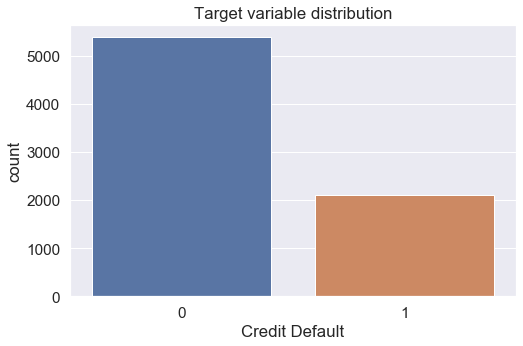

In [75]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=train_df)

plt.title('Target variable distribution')
plt.show()


In [76]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    4047
1    3156
Name: Credit Default, dtype: int64

In [96]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

Построение и оценка базовых моделей

Логистическая регрессия

In [97]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.64      0.79      0.71      4047
           1       0.62      0.43      0.51      3156

    accuracy                           0.63      7203
   macro avg       0.63      0.61      0.61      7203
weighted avg       0.63      0.63      0.62      7203

TEST

              precision    recall  f1-score   support

           0       0.78      0.79      0.78      1616
           1       0.44      0.42      0.43       634

    accuracy                           0.69      2250
   macro avg       0.61      0.61      0.61      2250
weighted avg       0.68      0.69      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1277  339
1                365  269


k ближайших соседей

In [98]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.82      0.79      4047
           1       0.74      0.66      0.70      3156

    accuracy                           0.75      7203
   macro avg       0.75      0.74      0.74      7203
weighted avg       0.75      0.75      0.75      7203

TEST

              precision    recall  f1-score   support

           0       0.84      0.79      0.81      1616
           1       0.53      0.61      0.56       634

    accuracy                           0.73      2250
   macro avg       0.68      0.70      0.69      2250
weighted avg       0.75      0.73      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1269  347
1                250  384


xgboost

In [99]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

[23:36:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      4047
           1       0.96      0.95      0.96      3156

    accuracy                           0.96      7203
   macro avg       0.96      0.96      0.96      7203
weighted avg       0.96      0.96      0.96      7203

TEST

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1616
           1       0.81      0.80      0.80       634

    accuracy                           0.89      2250
   macro avg       0.86      0.86      0.86      2250
weighted avg       0.89      0.89      0.89      2250

CONFUSION MATRIX

col_0

CatBoost

In [100]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.90      0.89      4047
           1       0.86      0.83      0.85      3156

    accuracy                           0.87      7203
   macro avg       0.87      0.87      0.87      7203
weighted avg       0.87      0.87      0.87      7203

TEST

              precision    recall  f1-score   support

           0       0.89      0.86      0.88      1616
           1       0.68      0.74      0.71       634

    accuracy                           0.83      2250
   macro avg       0.79      0.80      0.79      2250
weighted avg       0.83      0.83      0.83      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1396  220
1                164  470


Выбор лучшей модели и подбор гиперпараметров

In [101]:
model_xgb = xgb.XGBClassifier(random_state=21)

Подбор гиперпараметров

In [102]:
params = {'max_depth':[3, 5, 7, 10, 12],
          'learning_rate':[0.05, 0.20, 0.50, 0.1, 0.2, 0.3],
          'min_child_weights': [1, 2, 3, 5],
          'colsample_bytree': [0.75, 0.80, 0.90]}

In [103]:
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

Кросс-валидация

In [104]:
cv=StratifiedKFold(n_splits=4, random_state=21, shuffle=True)

Подбор лучших параметров модели и их взаимосвязи с помощью GridSearchCV

In [105]:
%%time

rs = GridSearchCV(model_xgb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

[00:20:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "min_child_weights" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:20:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 21min 48s


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=21, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_...
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, use_label_encoder=True,
                                     validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsa

Посмотрим лучшие параметры, которые нашёл GridSearchCV

In [106]:
rs.best_params_

{'colsample_bytree': 0.75,
 'learning_rate': 0.3,
 'max_depth': 12,
 'min_child_weights': 1}

In [107]:
rs.best_score_

0.8041145600164277

In [119]:
%%time

final_model = xgb.XGBClassifier(max_depth=12, learning_rate=0.3, min_child_weight=1,
                                colsample_bytree=0.75, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

[01:07:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4047
           1       1.00      1.00      1.00      3156

    accuracy                           1.00      7203
   macro avg       1.00      1.00      1.00      7203
weighted avg       1.00      1.00      1.00      7203

TEST

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1616
           1       0.90      0.83      0.87       634

    accuracy                           0.93      2250
   macro avg       0.92      0.90      0.91      2250
weighted avg       0.93      0.93      0.93      2250

CONFUSION MATRIX

col_0

In [116]:
final_modelx = xgb.XGBClassifier(max_depth=12, learning_rate=0.3, min_child_weight=1,
                                colsample_bytree=0.75, random_state=21)

Подбор оптимального размера выборки, кривая обучения

In [109]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

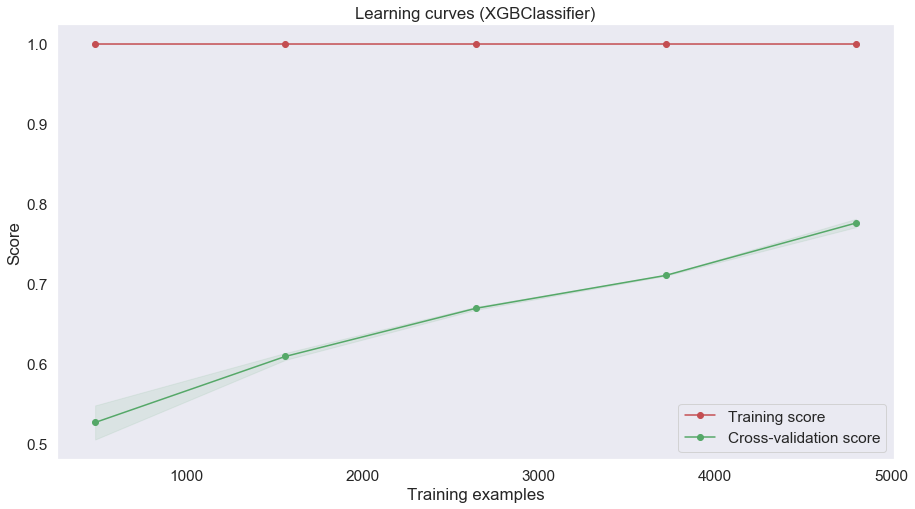

In [118]:
show_learning_curve_plot(final_modelx, X_train, y_train)

In [112]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

Выбор порога вероятности для определения класса

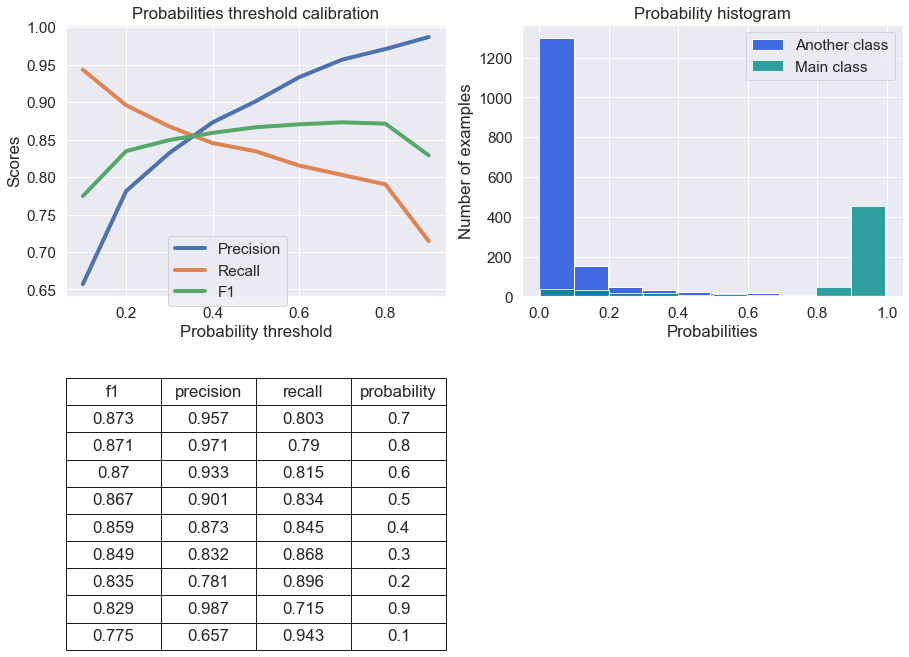

In [120]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [121]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

Важность признаков

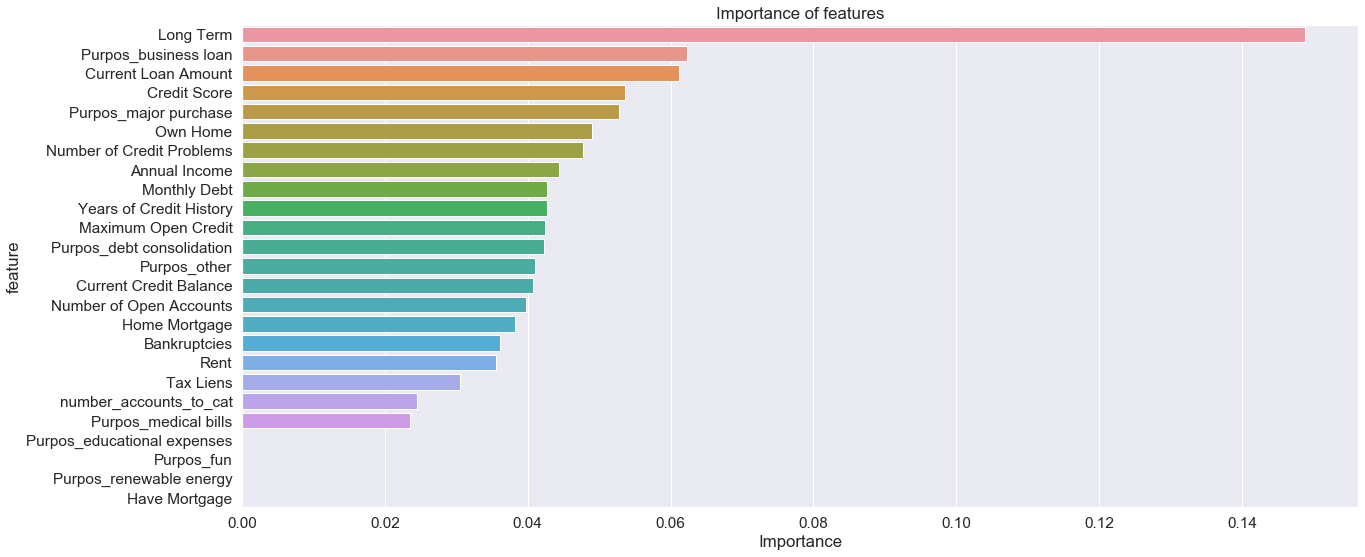

In [125]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

In [126]:
important_features_top

['Long Term',
 'Purpos_business loan',
 'Current Loan Amount',
 'Credit Score',
 'Purpos_major purchase',
 'Own Home',
 'Number of Credit Problems',
 'Annual Income',
 'Monthly Debt',
 'Years of Credit History',
 'Maximum Open Credit',
 'Purpos_debt consolidation',
 'Purpos_other',
 'Current Credit Balance',
 'Number of Open Accounts']

Теперь запустим нашу финальную модель с важными признаками, это может помочь увеличить качество модели, так как большое колличество признаков не означается лучшую метрику в итоге

In [127]:
final_model = xgb.XGBClassifier(max_depth=12, learning_rate=0.3, min_child_weight=1,
                                colsample_bytree=0.75, random_state=21)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

[01:20:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4047
           1       1.00      1.00      1.00      3156

    accuracy                           1.00      7203
   macro avg       1.00      1.00      1.00      7203
weighted avg       1.00      1.00      1.00      7203

TEST

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1616
           1       0.90      0.84      0.87       634

    accuracy                           0.93      2250
   macro avg       0.92      0.90      0.91      2250
weighted avg       0.93      0.93      0.93      2250

CONFUSION MATRIX

col_0

Метрики качества получились довольно хорошие

Сохранение финальной модели

In [130]:
import pickle as pk

In [131]:
with open("model.pk", 'wb') as file:
    pickle.dump(final_model, file)